# Static Data Analysis

We begin by importing all the necessary libraries

In [1]:
# For preprocessing
import os
from glob import glob
import statistics
import numpy as np

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline

# For training
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time

# For testing
from sklearn.metrics import confusion_matrix

# For exporting
import pickle

# Analysis

We begin our analysis by making a list of all the files that are available to us for analysis

In [2]:
# Path to parent directory of all malware
malware_dir = "../../Static_Analysis_Data/Malware"

# Path to parent directory of all benign hash names
benign_dir = "../../Static_Analysis_Data/Benign"

malwares = []
benigns = []

# Extract and save path of each data point
for malware in glob(os.path.join(malware_dir, "*")):
    malwares += glob(os.path.join(malware, "*"))
    
benigns = glob(os.path.join(benign_dir, "*"))

Now, lets have a look at our features to get a better understand of our data.

Our first feature is the count of the number of signs of a bad compiler.

This involves leaving checksum as 0x0, using characteristic 0x10F(makes the section executable) and also using blank names for sections of the PE file.
Good compilers generally do not generate or allow such features to exist.

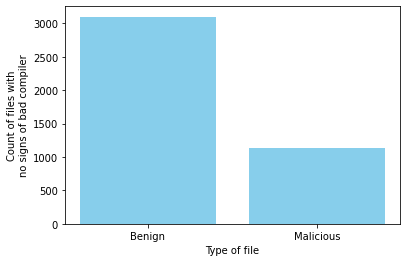

Benigns with no bad compiler features: 3099/5000 files
Malicious with no bad compiler features: 1138/5000 files


In [3]:
def signs_of_bad_compiler(f_path):
    count = 0
    f = open(f_path + "/Structure_Info.txt", "r", errors="ignore", encoding="utf8")
    lines = f.read()
    
    count += lines.count("CheckSum:                      0x0")
    
    count += lines.count("Characteristics:               0x10F")
    
    split = lines.split("----------PE Sections----------")
    if len(split) != 1:
        split = split[1].split("----------")
        split = split[0].split("\n")
        for line in split:
            split = line.split("0x0   Name:")
            if len(split) != 1:
                name = split[1].strip()
                if name == "":
                    count += 1
    return count

benign_vals = []
malware_vals = []

for file in benigns:
    benign_vals.append(signs_of_bad_compiler(file))

for file in malwares:
    malware_vals.append(signs_of_bad_compiler(file))

# creating the bar plot 
plt.bar(["Benign", "Malicious"],
        [benign_vals.count(0), malware_vals.count(0)],
        color ='skyblue') 
  
plt.ylabel("Count of files with\nno signs of bad compiler")
plt.xlabel("Type of file")
plt.show() 

print("Benigns with no bad compiler features: "
      + str(benign_vals.count(0))
      + "/5000 files")
print("Malicious with no bad compiler features: "
      + str(malware_vals.count(0))
      + "/5000 files")

Next, we'll run an analysis on all benign files to get the top 7 most common external functions they call.
We can use the same to determine the probablity of a file being benign by assuming it to be characteristic of benign apps.

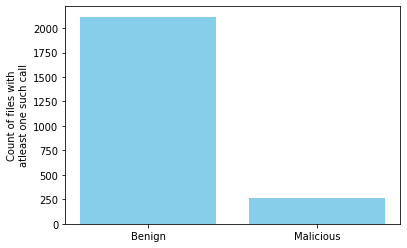

Benigns with common calls: 2116/5000 files
Malicious with common calls: 259/5000 files


In [4]:
good_props = ["MapViewOfFile", "ResumeThread", "SetWindowsHookExW",
              "CryptGenRandom", "CryptAcquireContextW", "CreateToolhelp32Snapshot",
              "CertDuplicateCertificateContext"]

def functions_of_benign(f_path):
    count = 0
    f = open(f_path + "/Structure_Info.txt", "r", errors="ignore", encoding="utf8")
    lines = f.read()
    for prop in good_props:
        count += lines.count(prop)
    return count

benign_vals = []
malware_vals = []

for file in benigns:
    benign_vals.append(functions_of_benign(file))

for file in malwares:
    malware_vals.append(functions_of_benign(file))

# creating the bar plot 
plt.bar(["Benign", "Malicious"],
        [len([i for i in benign_vals if i > 0]), len([i for i in malware_vals if i > 0])],
        color ='skyblue') 
  
plt.ylabel("Count of files with\natleast one such call") 
plt.show() 
print("Benigns with common calls: "
      + str(len([i for i in benign_vals if i > 0]))
      + "/5000 files")
print("Malicious with common calls: "
      + str(len([i for i in malware_vals if i > 0]))
      + "/5000 files")

Our next feature is the number of "Suspicious flag" warnings in the PE file

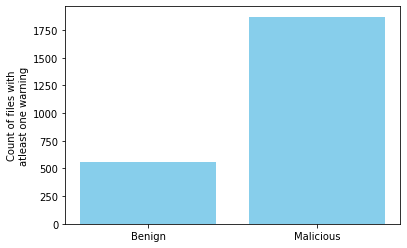

Benign files with warnings: 556/5000 files
Malicious files with warnings: 1870/5000 files


In [5]:
def num_of_warnings(f_path):
    count = 0
    f = open(f_path + "/Structure_Info.txt", "r", errors="ignore", encoding="utf8")
    lines = f.read()
    count += lines.count("Suspicious flags")
    return count

benign_vals = []
malware_vals = []

for file in benigns:
    benign_vals.append(num_of_warnings(file))

for file in malwares:
    malware_vals.append(num_of_warnings(file))

# creating the bar plot 
plt.bar(["Benign", "Malicious"],
        [len([i for i in benign_vals if i > 0]), len([i for i in malware_vals if i > 0])],
        color ='skyblue') 
  
plt.ylabel("Count of files with\natleast one warning") 
plt.show() 

print("Benign files with warnings: "
      + str(len([i for i in benign_vals if i > 0]))
      + "/5000 files")
print("Malicious files with warnings: "
      + str(len([i for i in malware_vals if i > 0]))
      + "/5000 files")

Finally, we get to our most important feature - Entropy.
The PE sections contain data which usually has a known entropy. Higher entropy can indicate packed data. Malicious files are commonly packed to avoid static analysis since the actual code is usually stored encrypted in one of the sections and will only be extracted at runtime.

We extract the minimum, maximum and the mean of all entropies from each file.

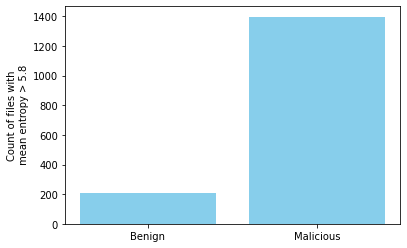

Benign files with mean entropy > 5.8: 210
Malicious files with mean entropy > 5.8: 1397


In [6]:
def calc_entropy(f_path):
    entropy = []
    f = open(f_path + "/Structure_Info.txt", "r", errors="ignore", encoding="utf8")
    lines = f.read()
    entropy_split = lines.split("Entropy: ")
    for each in entropy_split[1:]:
        entropy.append(float(each.split(" ")[0]))
    if not bool(entropy):
        return [0, 0, 0]
    return [min(entropy), max(entropy), statistics.mean(entropy)]

benign_vals = []
malware_vals = []

for file in benigns:
    benign_vals.append(calc_entropy(file))

for file in malwares:
    malware_vals.append(calc_entropy(file))

benign_count = 0
malware_count = 0

for each in benign_vals:
    if each[2] > 5.8:
        benign_count += 1
        
for each in malware_vals:
    if each[2] > 5.8:
        malware_count += 1

# creating the bar plot 
plt.bar(["Benign", "Malicious"],
        [benign_count, malware_count],
        color ='skyblue') 
  
plt.ylabel("Count of files with\n mean entropy > 5.8") 
plt.show() 

print("Benign files with mean entropy > 5.8: " + str(benign_count))
print("Malicious files with mean entropy > 5.8: " + str(malware_count))

# Training

First, we define a function to extract features by calling all the functions that we defined earlier.

In [7]:
def extract_features(f_path):
    
    features = [0, 0, 0, 0, 0, 0]  
    
    features[0] = signs_of_bad_compiler(f_path)
    
    features[1] = functions_of_benign(f_path)
    
    features[2] = num_of_warnings(f_path)
    
    features[3], features[4], features[5] = calc_entropy(f_path)
    
    return features

Next, we write the code to send files from our dataset for feature extraction

In [8]:
# Number of samples to take of each type. Set as a negative number to use entire dataset
limit = -1


x = []
y = []

i = 0
for file in benigns:
    x.append(extract_features(file))
    y.append(0)
    i += 1
    if i == limit:
        break

i = 0
for file in malwares:
    x.append(extract_features(file))
    y.append(1)
    i += 1
    if i == limit:
        break

x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

Now, onto the actual trainning.

We use Random Forest Classifier as the data is highly threshold based. Forest classifiers give good results on such data.

In [9]:
cls = RandomForestClassifier(n_estimators=50)
start = time.time()
cls.fit(x_train, y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")

Training time: 0.3051488399505615 seconds


# Testing

Now that our model is trained, we can test it's accuracy and speed

In [10]:
start = time.time()
accuracy = str(cls.score(x_test, y_test))
stop = time.time()
y_pred = cls.predict(x_test)
tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()

precision = tp/(tp + fp)
recall = tp/(tp + fn)
fscore =  2*((precision*recall)/(precision+recall))

print("Accuracy: " + accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F-score: ", fscore)
print(f"Testing time: {(stop - start)} seconds for {len(y_test)} predictions")

Accuracy: 0.97
Precision:  0.9669811320754716
Recall:  0.9738717339667459
F-score:  0.9704142011834319
Testing time: 0.032489776611328125 seconds for 2500 predictions


# Export Model

In [11]:
pickle.dump(cls, open("./static_model", 'wb'))